In [1]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Get UKBB risk variants

In [4]:
import json
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [5]:
def make_ukbb_prs(raw,sumstats,snps):
    
    print("{} PRS snps".format(len(snps)))
    
    #compile raw files
    compiled_raw=pd.read_csv(raw,delim_whitespace=True)
    
    #keep snps in list
    keep_snps=[]
    
    for x in snps:
        try:
            keep_snps.append([s for s in compiled_raw.columns if x in s][0])
        except:
            try:
                keep_snps.append([s for s in compiled_raw.columns if x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] in s][0])
            except:
                pass
    
    compiled_raw=compiled_raw[["IID"]+keep_snps]
    print("loading {} snps".format(len([x for x in compiled_raw.columns if ":" in x])))
    print([x for x in compiled_raw.columns if ":" in x])
    
    #format raw files
    compiled_raw=compiled_raw.set_index("IID")
    compiled_raw=compiled_raw.T
    compiled_raw["min_allele"]=compiled_raw.index.str.split("_").str[-1]
    
    #remove duplicates
    compiled_raw["snp"]=compiled_raw.index.str.split("_").str[0]
    compiled_raw=compiled_raw[~compiled_raw["snp"].duplicated()]
    del compiled_raw["snp"]
    
    compiled_raw.index=compiled_raw.index.str.rsplit(":",2).str[0]
    
    #reformat summary
    summary_merge=sumstats[["ID","A1","OR"]].copy()
    summary_merge=summary_merge.drop_duplicates(subset="ID",keep="first")
    summary_merge=summary_merge.set_index("ID")
    summary_merge.index=summary_merge.index.str.rsplit(":",2).str[0]
    
    #annotate the genotypes
    compiled_raw=pd.merge(compiled_raw,summary_merge, left_index=True,right_index=True,how="left")
    print("{} snps missing weight".format(len(compiled_raw[compiled_raw["OR"].isnull()])))
    
    compiled_raw["logOR"]=np.log2(compiled_raw["OR"])
    del compiled_raw["OR"]
    compiled_raw=compiled_raw[~compiled_raw["logOR"].isnull()] #remove null weights
    compiled_raw["logOR"]=np.where(compiled_raw["min_allele"]!=compiled_raw["A1"],compiled_raw["logOR"]*-1,compiled_raw["logOR"]) #orient the odds ratio
    print("switching {} genotypes".format(len(compiled_raw[compiled_raw["min_allele"]!=compiled_raw["A1"]]))) #number of mismatched genotypes

    del compiled_raw["min_allele"]
    del compiled_raw["A1"]

    #get beta values
    mp_beta=dict(zip(compiled_raw.index,compiled_raw["logOR"]))
    compiled_raw_switch=compiled_raw.iloc[:,:-1].T
    
    #align to all positive snps
    switch_snps=[k for k,v in mp_beta.items() if v < 0]
    
    compiled_raw_switch=compiled_raw_switch.fillna(0)
    
    for x in switch_snps:
        compiled_raw_switch[x]=2-compiled_raw_switch[x]
        
    compiled_raw_switch=compiled_raw_switch.T
    compiled_raw_switch["beta"]=compiled_raw_switch.index.map(mp_beta)
    compiled_raw_switch["beta"]=abs(compiled_raw_switch["beta"])
    compiled_raw_switch=compiled_raw_switch.astype(float)
    
    #compile weighted genotypes

    raw_prs=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0).sum(axis=0).reset_index()
    raw_prs.columns=["IID","PRS"]
    
    return(raw_prs)

In [6]:
def quantile_plot(df,form,num,lin_log):
    '''
    df: dataframe with PRS and pheno/cov in form
    prs: prs column
    form: formula for analysis
    num: number of quantiles
    '''
    
    if lin_log == "logistic":
        
        quant=[]
        odds=[]
        se=[]

        for i in range(num):
            quant.append(str((100/num)*i))
    
            #make groupings for logistic regression
            
            cases=df[(df["PRS"]>df["PRS"].quantile((1/num)*i))&(df["PRS"]<df["PRS"].quantile((1/num)*(i+1)))]["FID"].tolist()
            controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(melanoma_prs["PRS"]<melanoma_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
    
            df_filt=df[df["FID"].isin(cases+controls)]
            df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
            print(df_filt["group"].value_counts())
            
            if i != int(num/2):
                model=smf.logit(form,data=df_filt).fit()
                odds.append(np.exp(model.params.tolist()[1]))
                se.append(model.bse.tolist()[1])
            else:
                odds.append(1)
                se.append(0)
                
        df_odds=pd.DataFrame({"quant":quant,"odds":odds,"se":se})
        return(df_odds)

In [15]:
meqtls = pd.read_csv("meqtls_tads.csv")
all_snps = []
for i, row in meqtls.iterrows():
    l = row["SNP"].split(":")
    all_snps.append(l[0]+":"+l[1]+":"+l[2]+":"+l[3])
    all_snps.append(l[0]+":"+l[1]+":"+l[3]+":"+l[2])
all_meqtls = pd.DataFrame(np.repeat(meqtls.values, 2, axis=0))
all_meqtls.columns = meqtls.columns
all_meqtls["SNP"] = all_snps
all_meqtls

,Unnamed: 0,num,cancer_type,rsid,snp_position,alleles,probes,probe_position,probe_gene,beta,status,r,p-value,cancer,chr,bp,SNP,TAD Type
0,0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,MYADML,-1.24,-40.26,-0.9,0.0,BLCA,chr2,33952621,2:33952621:G:A,Boundary
1,0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,MYADML,-1.24,-40.26,-0.9,0.0,BLCA,chr2,33952621,2:33952621:A:G,Boundary
2,1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.59,-0.9,0.0,BLCA,chr2,33954560,2:33954560:C:T,Boundary
3,1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.59,-0.9,0.0,BLCA,chr2,33954560,2:33954560:T:C,Boundary
4,2,2,BLCA,rs7574695,chr2:33953186,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.35,-0.9,0.0,BLCA,chr2,33953186,2:33953186:C:T,Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472279,1236139,1236139,UCEC,rs10903612,chr10:2018353,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,0.00001,UCEC,chr10,2018353,10:2018353:T:C,Neither
2472280,1236140,1236140,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,0.00001,UCEC,chr10,2019373,10:2019373:C:T,Neither
2472281,1236140,1236140,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,0.00001,UCEC,chr10,2019373,10:2019373:T:C,Neither
2472282,1236141,1236141,UCEC,rs11002432,chr10:79931884,C/T,cg15849445,chr10:80635973,NaN,0.58,4.58,0.35,0.00001,UCEC,chr10,79931884,10:79931884:C:T,Boundary


In [16]:
all_meqtls = all_meqtls.rename(columns={"SNP":"Var1_ID"})

In [116]:
snps=pd.read_csv("../data/supplemental/Supplemental_Table_3.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]
mp_variant=dict(zip(snps["proxy_snp"],snps["proxy_variant"]))

In [117]:
len([x.replace("-",".") for x in snps["file"].unique().tolist()])

129

In [9]:
def fdr(df, p):
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)

In [10]:
ukbb=pd.read_csv("risk_score/compiled_ukbb.tsv", delimiter="\t")
ukbb = fdr(ukbb, "Var1_Pval")
ukbb

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_NonMissing,Analysis_Type,Num_Cases,N_Iter,Converged,Raw_LRT_pval,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval_(LRT),Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,fdr,-log10(fdr)
0,C00-C14,5:180060804:G:C,5:180060804,C:0.54094,372977,logistic,939,10,1,0.011721,0.011663,0.889889,0.046253,0.011721,0.468854,0.240765,0.675122,0.170617
1,C40-C41,5:180060804:G:C,5:180060804,C:0.54094,372977,logistic,146,12,1,0.020257,0.020376,0.761781,0.117316,0.020257,0.810262,0.240765,0.798290,0.097839
2,C97-C97,5:180060804:G:C,5:180060804,C:0.54094,372977,logistic,241,12,1,0.024077,0.024053,0.813926,0.091250,0.024077,0.963061,0.240765,0.803726,0.094892
3,C15-C26,5:180060804:G:C,5:180060804,C:0.54094,372977,logistic,7299,8,1,0.036303,0.036276,0.965362,0.016836,0.036303,1.000000,0.290424,0.852155,0.069481
4,C43-C44,5:180060804:G:C,5:180060804,C:0.54094,372977,logistic,14219,8,1,0.057997,0.057850,0.977124,0.012200,0.057997,1.000000,0.386648,0.863698,0.063638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,C00-C14,2:201132135:A:G,2:201132135,A:0.94966,382839,logistic,978,10,1,0.906918,0.908915,1.011950,0.103798,0.906918,1.000000,1.000000,0.999864,0.000059
4106,C51-C58,2:201132135:A:G,2:201132135,A:0.94966,382839,logistic,2756,11,1,0.913795,0.919374,1.006330,0.062319,0.913795,1.000000,1.000000,0.999864,0.000059
4107,C97-C97,2:201132135:A:G,2:201132135,A:0.94966,382839,logistic,248,12,1,0.978409,0.980317,1.005080,0.205333,0.978409,1.000000,1.000000,0.999864,0.000059
4108,C40-C41,2:201132135:A:G,2:201132135,A:0.94966,382839,logistic,149,12,1,1.000000,0.990844,1.003050,0.265116,1.000000,1.000000,1.000000,0.999864,0.000059


In [11]:
fdr_thresh=0.2

In [12]:
#get significant UKBB associations 
    #filter for cancer associations: Outcome ICD10 codes - C
    
ukbb_sig=ukbb[ukbb["fdr"]<fdr_thresh]
ukbb_sig=ukbb_sig[ukbb_sig["Outcome"].str.startswith("C")]
#ukbb_sig["proxy_variant"]=ukbb_sig["Var1_ID"].map(mp_variant).fillna(ukbb_sig["Var1_ID"])

#annotate dataframe
# ukbb_sig_snps=ukbb_sig["proxy_variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in ukbb_sig["proxy_variant"].tolist()]
# snps["ukbb"]=np.where(snps["proxy_variant"].isin(ukbb_sig_snps),"ukbb","no")

In [14]:
ukbb_sig[]

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_NonMissing,Analysis_Type,Num_Cases,N_Iter,Converged,Raw_LRT_pval,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval_(LRT),Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,fdr,-log10(fdr)
90,C50-C50,11:22605592:C:T,11:22605592,C:0.806521,378752,logistic,10770,10,1,8.481389e-04,7.953720e-04,0.943267,0.017412,8.481390e-04,3.392560e-02,3.392560e-02,1.918573e-01,0.717022
330,C97-C97,5:112139424:A:G,5:112139424,A:0.847015,378917,logistic,243,12,1,9.282320e-05,4.487740e-05,0.639234,0.109656,9.282320e-05,3.712930e-03,3.712930e-03,2.305576e-02,1.637220
345,C50-C50,5:56085225:C:T,5:56085225,C:0.761093,379687,logistic,10793,10,1,2.628435e-06,3.041170e-06,1.081060,0.016696,2.628430e-06,1.051370e-04,1.051370e-04,2.083201e-03,2.681269
360,C50-C50,2:213432392:G:A,2:213432392,G:0.624525,380535,logistic,10786,10,1,9.072866e-04,8.918240e-04,0.953405,0.014361,9.072870e-04,3.629150e-02,3.629150e-02,1.918573e-01,0.717022
960,C50-C50,2:213423503:C:T,2:213423503,C:0.782351,382839,logistic,10868,10,1,3.870388e-04,3.629170e-04,0.942334,0.016658,3.870390e-04,1.548160e-02,1.548160e-02,1.242991e-01,0.905532
990,C43-C44,2:202143928:T:C,2:202143928,C:0.731979,382839,logistic,14560,8,1,4.630690e-25,1.824160e-25,0.871033,0.013239,4.630690e-25,1.852280e-23,1.852280e-23,7.497298e-22,21.125095
991,C60-C63,2:202143928:T:C,2:202143928,C:0.731979,382839,logistic,7096,11,1,5.444154e-04,5.795430e-04,1.070680,0.019847,5.444150e-04,2.177660e-02,7.258870e-03,1.494776e-01,0.825424
1365,C51-C58,16:74714604:C:T,16:74714604,C:0.927648,380831,logistic,2740,11,1,1.087768e-03,8.411260e-04,0.848543,0.049188,1.087770e-03,4.351070e-02,4.351070e-02,1.918573e-01,0.717022
1515,C43-C44,16:89818340:G:C,16:89818340,G:0.584587,382659,logistic,14555,8,1,9.965952e-11,9.305360e-11,0.924265,0.012158,9.965950e-11,3.986380e-09,3.986380e-09,9.561257e-08,7.019485
2010,C43-C44,16:89884502:C:T,16:89884502,T:0.577376,377468,logistic,14350,8,1,9.422251e-13,1.073170e-12,1.092080,0.012370,9.422250e-13,3.768900e-11,3.768900e-11,2.205364e-09,8.656520


In [13]:
print("{} UKBB associations from {} IP components".format(len(snps[snps["ukbb"]=="ukbb"]),len(snps[snps["ukbb"]=="ukbb"]["file"].unique())))

NameError: name 'snps' is not defined

In [17]:
#ukbb_annot=pd.merge(ukbb_sig, snps, on="proxy_variant", how="left")
ukbb_annot = pd.merge(ukbb_sig, all_meqtls, on="Var1_ID")
ukbb_annot["ukbb_a1"]=ukbb_annot["Var1_MAF"].str.split(":").str[0]
#ukbb_annot["beta_match"]=np.where(ukbb_annot['ukbb_a1']!=ukbb_annot["A1"],ukbb_annot["beta"]*-1,ukbb_annot["beta"])
ukbb_annot["logOR"]=np.log10(ukbb_annot["Var1_OR"])
#ukbb_annot["ref"]=ukbb_annot["proxy_variant"].str.split(":").str[2]

In [33]:
ukbb_nodubs = ukbb_annot.drop_duplicates(subset=['Var1_ID'])
ukbb_nodubs["TAD Type"].value_counts()

Boundary    11
Active       4
Inactive     3
Mixed        1
Name: TAD Type, dtype: int64

In [123]:
pheno_group=pd.read_csv("../data/networkx/networkx.group.csv")
pheno_group["nodes"]=pheno_group["nodes"].str.replace(".","-")
mp_group=dict(zip(pheno_group["nodes"],pheno_group["group"]))

In [124]:
ukbb_annot["group"]=ukbb_annot["file"].map(mp_group)

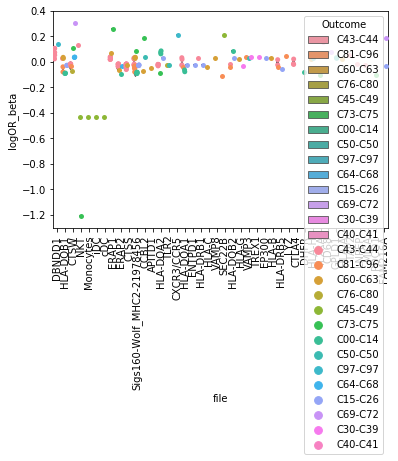

In [125]:
ukbb_annot["logOR_beta"]=np.where(ukbb_annot["beta_match"]<0,ukbb_annot["logOR"]*-1,ukbb_annot["logOR"])
sns.boxplot(x="file",y="logOR_beta",hue="Outcome",data=ukbb_annot)
sns.swarmplot(x="file",y="logOR_beta",hue="Outcome",dodge=True,data=ukbb_annot)
plt.xticks(rotation=90)
plt.savefig("../plots/fig5/ukbb.logOR.pdf")

In [23]:
ukbb_annot["Outcome"].value_counts()

C43-C44    9
C50-C50    6
C51-C58    2
C60-C63    2
C97-C97    1
C76-C80    1
Name: Outcome, dtype: int64

In [127]:
ukbb_annot[ukbb_annot["file"]=="EP300"]

,Unnamed: 0,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_Missing,Analysis_Type,Converged,Var1_Pval,Var1_OR,...,proxy_snp,chr,cis tss,ukbb,ukbb_a1,beta_match,logOR,ref,group,logOR_beta
77,0,C15-C26,rs72728480,8:136257870,G:0.7916,123256,logistic,1,0.002389,1.06685,...,rs72728480,8,NaN,ukbb,G,0.112807,0.028103,G,group2,0.028103


In [18]:
### Breat Cancer
annot_short=ukbb_annot[["Var1_ID", "ukbb_a1","Var1_OR","Outcome"]]
annot_short_melanoma=annot_short[annot_short["Outcome"]=="C50-C50"]
annot_short_melanoma.columns=["ID","A1","OR","Outcome"]

In [19]:
melanoma_prs=make_ukbb_prs("/cellar/users/mpagadal/projects/tad-meqtl/data/dosage/ukbb.tad.meqtl.raw",annot_short_melanoma,annot_short_melanoma["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
melanoma_prs=pd.merge(melanoma_prs,icd,on="IID",how="left")

6 PRS snps
loading 6 snps
['11:22605592:C:T_T', '5:56085225:C:T_T', '2:213432392:G:A_A', '2:213423503:C:T_T', '2:213542405:C:T_T', '2:47785260:T:C_T']
0 snps missing weight
switching 6 genotypes


Text(0.5, 0, 'PRS')

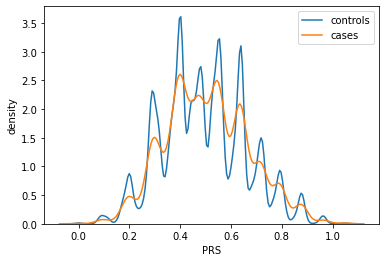

In [24]:
sns.kdeplot(melanoma_prs[melanoma_prs["C50-C50"]==0]["PRS"],label="controls")
sns.kdeplot(melanoma_prs[melanoma_prs["C50-C50"]==1]["PRS"],label="cases")
plt.legend()
plt.ylabel("density")
plt.xlabel("PRS")

In [25]:
cat1 = melanoma_prs[melanoma_prs["C50-C50"]==0]
cat2 = melanoma_prs[melanoma_prs["C50-C50"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

8.463210908407618e-14

In [26]:
melanoma_prs["melanoma"]=melanoma_prs["C50-C50"]
melanoma_odds=quantile_plot(melanoma_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    136600
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.108345
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    132839
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.109143
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    134986
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.115600
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    118296
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.113226
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    139895
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.114742
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    130931
Name: group, dtype: int64


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    142223
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.117036
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    139144
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.116524
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    125072
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.118023
         Iterations 10


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    143396
0     26361
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.119956
         Iterations 10


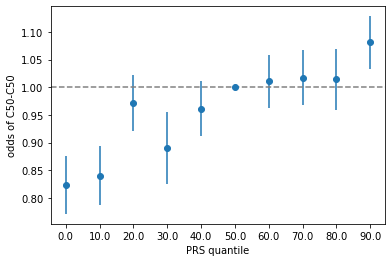

In [28]:
plt.errorbar(x=melanoma_odds["quant"].tolist(),y=melanoma_odds["odds"].tolist(),yerr=melanoma_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile")
plt.ylabel("odds of C50-C50")
plt.savefig("plots/C50-C50_PRS_quantile.pdf")
plt.axhline(1,linestyle="--",color="gray")

### Melanoma

#### C43-C44 PRS

In [24]:
#group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
annot_short=ukbb_annot[["Var1_ID", "ukbb_a1","Var1_OR","Outcome"]]
annot_short_melanoma=annot_short[annot_short["Outcome"]=="C43-C44"]
annot_short_melanoma.columns=["ID","A1","OR","Outcome"]

In [36]:
annot_short_melanoma

,ID,A1,OR,Outcome
5,2:202143928:T:C,C,0.871033,C43-C44
8,16:89818340:G:C,G,0.924265,C43-C44
9,16:89884502:C:T,T,1.092080,C43-C44
12,9:22005330:T:G,T,1.085540,C43-C44
16,16:89828862:T:C,T,0.937713,C43-C44
17,11:46722221:T:C,C,1.047120,C43-C44
18,11:47236405:C:G,G,1.052430,C43-C44
19,16:89844043:T:C,T,1.107610,C43-C44
20,11:46852839:A:G,G,1.050900,C43-C44


In [26]:
melanoma_prs=make_ukbb_prs("/cellar/users/mpagadal/projects/tad-meqtl/data/dosage/ukbb.tad.meqtl.raw",annot_short_melanoma,annot_short_melanoma["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
melanoma_prs=pd.merge(melanoma_prs,icd,on="IID",how="left")

9 PRS snps
loading 9 snps
['2:202143928:T:C_T', '16:89818340:G:C_C', '16:89884502:C:T_C', '9:22005330:T:G_G', '16:89828862:T:C_C', '11:46722221:T:C_T', '11:47236405:C:G_C', '16:89844043:T:C_C', '11:46852839:A:G_A']
0 snps missing weight
switching 9 genotypes


Text(0.5, 0, 'PRS')

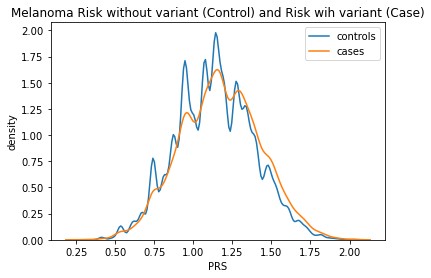

In [37]:
sns.kdeplot(melanoma_prs[melanoma_prs["C43-C44"]==0]["PRS"],label="controls")
sns.kdeplot(melanoma_prs[melanoma_prs["C43-C44"]==1]["PRS"],label="cases")
plt.legend()
plt.title("Melanoma Risk without variant (Control) and Risk wih variant (Case)")
plt.ylabel("density")
plt.xlabel("PRS")

In [32]:
cat1 = melanoma_prs[melanoma_prs["C43-C44"]==0]
cat2 = melanoma_prs[melanoma_prs["C43-C44"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

6.197962263703698e-65

In [28]:
melanoma_prs["melanoma"]=melanoma_prs["C43-C44"]
melanoma_odds=quantile_plot(melanoma_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    142860
0     39788
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.142710
         Iterations 8
1    137311
0     39788
Name: group, dtype: int64


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.147038
         Iterations 8
1    140015
0     39788
Name: group, dtype: int64


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.147085
         Iterations 8
1    143367
0     39788
Name: group, dtype: int64


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.147561
         Iterations 8
1    143166
0     39788
Name: group, dtype: int64


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.149984
         Iterations 9
1    144358
Name: group, dtype: int64


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    141072
0     39788
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.154169
         Iterations 8


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    138669
0     39788
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.158955
         Iterations 8


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    144745
0     39788
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.162270
         Iterations 8
1    143948
0     39788
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.172185
         Iterations 8


<ipython-input-6-d4796fc2697e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


In [35]:
melanoma_prs

,IID,PRS,FID,D55-D59,D80-D89,E70-E90,I70-I79,K20-K31,K50-K52,K70-K77,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,melanoma
0,5309711,1.276185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5607583,0.988487,5607583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016920,0.001305,0.004770,-0.006398,-0.002327,-0.004221,-0.015524,-0.005614,-0.001290,0.0
2,3534526,1.183223,3534526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012710,-0.003276,0.006141,0.001139,0.003370,-0.008427,-0.001921,0.009822,-0.006333,0.0
3,5138852,0.698814,5138852.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.003246,-0.000597,0.012908,0.004790,-0.008045,-0.000175,0.002480,-0.006394,0.008965,0.0
4,2187179,1.384206,2187179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008452,-0.000948,-0.001641,0.004532,0.003766,0.007023,-0.010404,0.001035,0.003554,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498599,3387495,0.884845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498600,1801702,1.154479,1801702.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003028,0.001570,0.000221,0.007563,-0.002930,-0.005763,0.006989,-0.004429,-0.003914,1.0
498601,4639336,1.255813,4639336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.013115,-0.001096,0.000925,-0.002479,0.008129,-0.003516,0.003790,0.006919,-0.006315,0.0
498602,2621795,1.175139,2621795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000022,0.001337,0.007938,-0.006859,0.000822,-0.006550,0.003858,-0.002301,0.004050,0.0


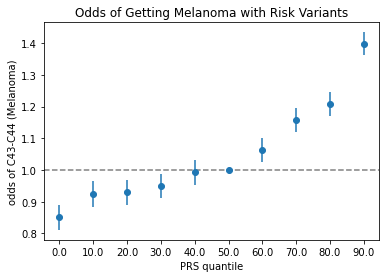

In [29]:
plt.errorbar(x=melanoma_odds["quant"].tolist(),y=melanoma_odds["odds"].tolist(),yerr=melanoma_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile")
plt.ylabel("odds of C43-C44 (Melanoma)")
plt.title("Odds of Getting Melanoma with Risk Variants")
plt.savefig("plots/C43-C44_PRS_quantile.pdf")
plt.axhline(1,linestyle="--",color="gray")

#### MHC II signature

In [134]:
mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

In [135]:
mhcII_prs=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",mhcII_sumstats,mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
mhcII_prs=pd.merge(mhcII_prs,icd,on="IID",how="left")

9 PRS snps
loading 9 snps
['6:32586908:A:G_G', '6:32634405:T:C_C', '6:32692735:T:A_A', '6:32575658:G:C_C', '6:32683121:A:G_G', '6:32612397:G:A_A', '6:32592796:C:T_T', '6:32584625:G:A_A', '6:32581582:G:C_C']
0 snps missing weight
switching 9 genotypes


Text(0.5, 0, 'PRS')

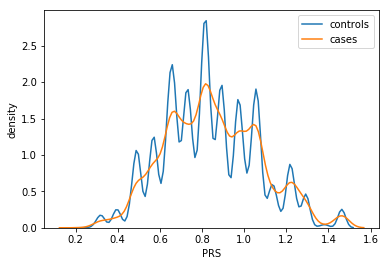

In [136]:
sns.kdeplot(mhcII_prs[mhcII_prs["C43-C44"]==0]["PRS"],label="controls")
sns.kdeplot(mhcII_prs[mhcII_prs["C43-C44"]==1]["PRS"],label="cases")
plt.ylabel("density")
plt.xlabel("PRS")

In [137]:
cat1 = mhcII_prs[mhcII_prs["C43-C44"]==0]
cat2 = mhcII_prs[mhcII_prs["C43-C44"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

6.245912960867174e-17

In [138]:
mhcII_prs["melanoma"]=mhcII_prs["C43-C44"]
mhcII_odds=quantile_plot(mhcII_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1    143985
0     80276
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.150578
         Iterations 8
1    143902
0     80276
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.153056
         Iterations 8
1    138826
0     80276
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.154656
         Iterations 8
1    141874
0     80276
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.152008
         Iterations 8
1    142461
0     80276
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.154128
         Iterations 8
1    130848
0     64566
Name: group, dtype: int64
1    149184
0     56841
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.156783
         Iterations 8
1    132511
0     66779
Name: group, d

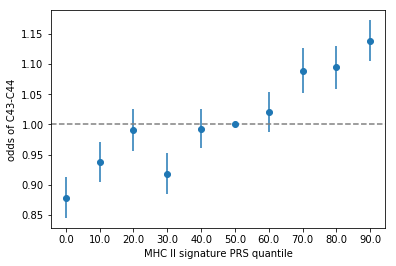

In [139]:
plt.errorbar(x=mhcII_odds["quant"].tolist(),y=mhcII_odds["odds"].tolist(),yerr=mhcII_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of C43-C44")
plt.axhline(1,linestyle="--",color="gray")

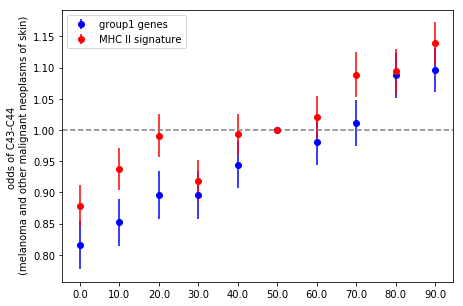

In [140]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=group1_odds["quant"].tolist(),y=group1_odds["odds"].tolist(),yerr=group1_odds["se"].tolist(),fmt="o",color="blue",label="group1 genes")
plt.errorbar(x=mhcII_odds["quant"].tolist(),y=mhcII_odds["odds"].tolist(),yerr=mhcII_odds["se"].tolist(),fmt="o",color="red",label="MHC II signature")
plt.ylabel("quantile")
plt.ylabel("odds of C43-C44 \n (melanoma and other malignant neoplasms of skin)")
plt.axhline(1,linestyle="--",color="gray")
plt.legend()
plt.savefig("../plots/fig5/mhcII.ukbb.quantile.pdf")

#### validation

In [183]:
group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)

In [184]:
geneva_prs=make_ukbb_prs("../data/genotypes/geneva_melanoma/geneva.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000187v1_geneva_melanoma/phenotypes/phs000187.v1.pht000814.v1.p1.c1.Melanoma_Data.GRU.txt.gz",comment="#",delimiter="\t")
pheno["case_control"]=pheno["case_control"].map({1:1,2:0,3:np.nan})
pheno["pheno"]=pheno["case_control"]
pheno=pheno.rename(columns={"Geneva_ID_":"IID"})
pheno["age"]=pheno["Age_at_DX"].fillna(pheno["Control_Age_at_DX"])
geneva_prs=pd.merge(geneva_prs,pheno[["IID","pheno","age","Gender_","Breslow_tumor_thickness","family_history"]],on="IID",how="left")
geneva_prs["sex"]=geneva_prs["Gender_"].map({"M":0,"F":1})
pcs=pd.read_csv("/cellar/users/mpagadal/ancestry-analysis/geneva/all.cluster.mds",delim_whitespace=True)
pcs["IID"]=pcs["IID"].astype(str)
geneva_prs["IID"]=geneva_prs["IID"].astype(str)

52 PRS snps
loading 52 snps
['5:96374150:G:A_G', '5:96374150:G:A_G', '1:151119769:T:A_A', '5:96200770:A:T_A', '1:150597890:G:A_G', '6:32438298:A:G_G', '6:32606941:T:C_T', '6:32605295:C:T_T', '5:96230122:G:T_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:C:T_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:T:C_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:G:A_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:C:T_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:C:T_C', '6:32660784:C:G_C', '11:65394322:A:G_G', '6:32796793:G:A_A', '6:32636866:A:T_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:G:A_G', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:T:G_T', '11:65580638:T:G_G', '1:150618632:A:C_A', '6:32586908:G:A_G', '6:32634405:C:T_C', '6:32692735:A:T_A', '6:32575658:G:C_C', '6:32683121:G:A_

In [185]:
geneva_prs=pd.merge(geneva_prs,pcs,on="IID",how="left")

In [186]:
geneva_prs["FID"]=geneva_prs["IID"]

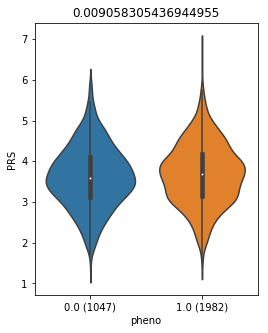

In [187]:
f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=geneva_prs)
cat1 = geneva_prs[(geneva_prs["pheno"]==0)]
cat2 = geneva_prs[(geneva_prs["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(geneva_prs[geneva_prs["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))

plt.savefig("../plots/fig5/mhcII.geneva.pdf")

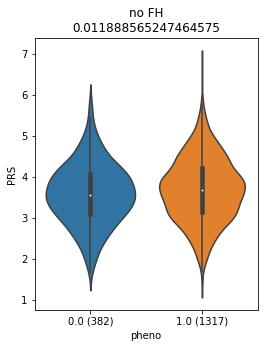

In [188]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=1]
f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=geneva_prs_fh)
cat1 = geneva_prs_fh[(geneva_prs_fh["pheno"]==0)]
cat2 = geneva_prs_fh[(geneva_prs_fh["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(geneva_prs_fh[geneva_prs_fh["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title("no FH\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/fig5/mhcII.geneva.no.fh.pdf")

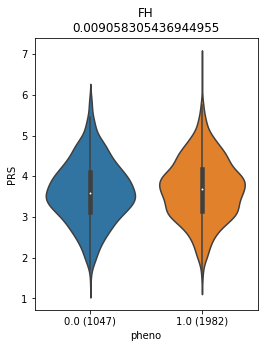

In [189]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=0]

f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=geneva_prs_fh)
cat1 = geneva_prs_fh[(geneva_prs_fh["pheno"]==0)]
cat2 = geneva_prs_fh[(geneva_prs_fh["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(geneva_prs_fh[geneva_prs_fh["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title("FH\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]
plt.savefig("../plots/fig5/mhcII.geneva.fh.pdf")

In [190]:
geneva_odds=quantile_plot(geneva_prs,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.615695
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601438
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.606957
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.611543
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.609890
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    698
1    303
Name: group, dtype: int64


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    709
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601442
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    670
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.599981
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    705
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.602801
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    698
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601029
         Iterations 5


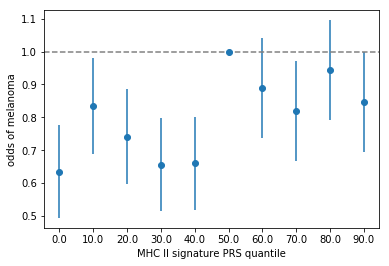

In [191]:
plt.errorbar(x=geneva_odds["quant"].tolist(),y=geneva_odds["odds"].tolist(),yerr=geneva_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.geneva.quantile.pdf")

In [192]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=0]
geneva_odds=quantile_plot(geneva_prs_fh,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.615695
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601438
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.606957
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.611543
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.609890
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    698
1    303
Name: group, dtype: int64


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    709
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601442
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    670
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.599981
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    705
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.602801
         Iterations 5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    698
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601029
         Iterations 5


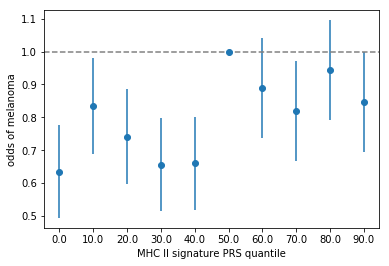

In [193]:
plt.errorbar(x=geneva_odds["quant"].tolist(),y=geneva_odds["odds"].tolist(),yerr=geneva_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.fh.geneva.quantile.pdf")

In [194]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=1]
geneva_odds=quantile_plot(geneva_prs_fh,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.491646
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.484702
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    488
1    170
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.491452
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.492295
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.486284
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    395
1    169
Name: group, dtype: int64


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    398
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.485771
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    377
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.483457
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    392
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.462387
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    393
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.467444
         Iterations 6


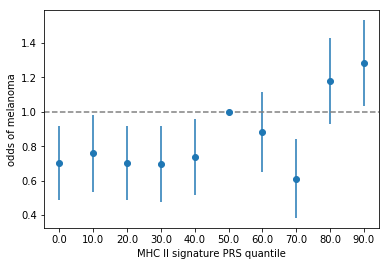

In [195]:
plt.errorbar(x=geneva_odds["quant"].tolist(),y=geneva_odds["odds"].tolist(),yerr=geneva_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.fh.geneva.quantile.pdf")

### Prostate cancer

In [154]:
prostate_group1_sumstats=ukbb_annot[(ukbb_annot["Outcome"]=="C60-C63")&(ukbb_annot["group"]=="group1")][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
prostate_group1_sumstats.columns=["ID","A1","OR","Outcome"]
prostate_mhcII_sumstats=ukbb_annot[(ukbb_annot["Outcome"]=="C60-C63")&(ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456")][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
prostate_mhcII_sumstats.columns=["ID","A1","OR","Outcome"]
prostate_sumstats=prostate_group1_sumstats.append(prostate_mhcII_sumstats)
prostate_sumstats=prostate_sumstats.drop_duplicates()
prostate_prs=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
prostate_prs=pd.merge(prostate_prs,icd,on="IID",how="left")

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:C:G_G', '6:29910358:C:G_G', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 11 genotypes


In [155]:
prostate_prs["prostate"]=prostate_prs["C60-C63"]
prostate_odds=quantile_plot(prostate_prs,"prostate ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1    142425
0    115227
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.074662
         Iterations 12
1    141721
0    115227
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.075580
         Iterations 12
1    137032
0    115227
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.075361
         Iterations 12
1    141567
0    115227
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.076973
         Iterations 12
1    142690
0    115227
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.077062
         Iterations 12
1    140283
0     91781
Name: group, dtype: int64
1    143821
0     91207
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.077139
         Iterations 12
1    139694
0     96764
Name: gr

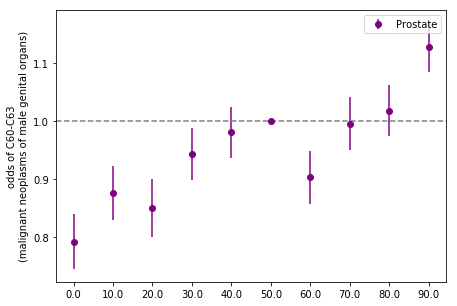

In [156]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=prostate_odds["quant"].tolist(),y=prostate_odds["odds"].tolist(),yerr=prostate_odds["se"].tolist(),fmt="o",color="purple",label="Prostate")
plt.ylabel("quantile")
plt.ylabel("odds of C60-C63\n(malignant neoplasms of male genital organs)")
plt.axhline(1,linestyle="--",color="gray")
plt.legend()
plt.savefig("../plots/fig5/ukbb.prostate.quantile.pdf")

In [157]:
prostate_group1_sumstats[prostate_group1_sumstats["ID"].isin(group1_mhcII_sumstats["ID"].tolist())]

,ID,A1,OR,Outcome
104,1:150658287:A:G,A,0.934438,C60-C63


#### Validation

In [158]:
ellipse_prs=make_ukbb_prs("../data/genotypes/ellipse/ellipse.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())
#add phenotypind
pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/phenotypes/pheno_affection_status.txt",delimiter="\t",header=None)
pheno[2]=pheno[2].map({1:0,2:1})
mp_pheno=dict(zip(pheno[1],pheno[2]))
ellipse_prs["pheno"]=ellipse_prs["IID"].map(mp_pheno)
cov=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/covs/age-pcs-fh",delimiter="\t")
ellipse_prs=pd.merge(ellipse_prs,cov,on="IID",how="left")
ellipse_prs["FH_PROS"]=ellipse_prs["FH_PROS"].replace(-9,0)

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:T:C_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:A:G_A', '1:150658287:A:G_G', '6:29909372:C:G_C', '6:29910358:C:G_C', '6:32659609:T:C_C', '6:31783507:G:C_G']
0 snps missing weight
switching 8 genotypes


In [159]:
ellipse_prs["FID"]=ellipse_prs["IID"]
ellipse_odds=quantile_plot(ellipse_prs,"pheno ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    27031
1     8730
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.627846
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    27031
1     8446
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.628889
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    27031
1     8675
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.629016
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    27031
1     8352
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.629683
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    27031
1     6775
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.627535
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    21970
1     8354
Name: group, dtype: int64


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    21859
1     8683
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626779
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    22546
1     7503
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626594
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    21751
1     8843
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626177
         Iterations 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0    21562
1     9069
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.625181
         Iterations 6


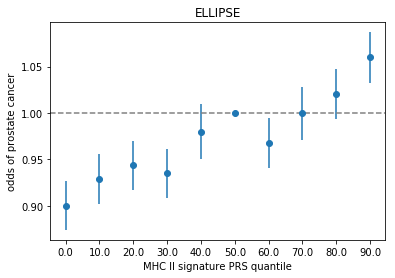

In [160]:
plt.errorbar(x=ellipse_odds["quant"].tolist(),y=ellipse_odds["odds"].tolist(),yerr=ellipse_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.title("ELLIPSE")
plt.savefig("../plots/fig5/ellipse.prostate.quantile.pdf")

In [161]:
ellipse_prs.head()

,IID,PRS,pheno,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,age,FH_PROS
0,0008701_0008701,0.869778,0,0008701_0008701,0.102039,-0.337532,-0.322556,0.131722,0.230461,0.122300,-0.144057,-0.018040,-0.009445,-0.073490,69.0,0.0
1,0028701_0028701,1.202431,0,0028701_0028701,-0.405513,-0.776644,-0.845495,0.429247,0.059246,0.342019,-0.132598,0.154175,-0.082170,-0.109072,62.0,0.0
2,0032003_0032003,1.000612,0,0032003_0032003,-0.073685,-0.614933,-0.434308,0.421452,-0.097652,0.331767,-0.228096,-0.125093,0.208555,-0.060504,51.0,1.0
3,0033901_0033901,1.489863,0,0033901_0033901,-0.304837,-0.440083,-0.593210,0.347532,-0.125469,0.174796,0.060199,0.104716,-0.013088,0.151564,54.0,0.0
4,0038804_0038804,1.045834,0,0038804_0038804,-0.200810,-0.418516,-0.490842,0.230205,-0.358742,-0.189175,0.028771,-0.137533,0.114615,0.045162,44.0,0.0


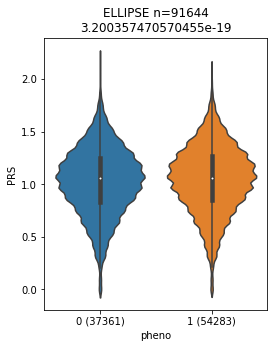

In [162]:
f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=ellipse_prs)
cat1 = ellipse_prs[(ellipse_prs["pheno"]==0)]
cat2 = ellipse_prs[(ellipse_prs["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(ellipse_prs[ellipse_prs["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title("ELLIPSE n="+str(len(ellipse_prs))+"\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]
plt.savefig("../plots/fig5/ellipse.prs.pdf")

### filter for European individuals

In [163]:
ellipse_eur=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/patients/genetic-ancestry/sklearn.European.all.txt",header=None,delimiter="\t")

In [164]:
ellipse_prs_eur=ellipse_prs[ellipse_prs["IID"].isin(ellipse_eur[0].tolist())]

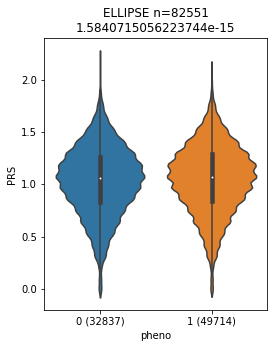

In [165]:
f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=ellipse_prs_eur)
cat1 = ellipse_prs_eur[(ellipse_prs_eur["pheno"]==0)]
cat2 = ellipse_prs_eur[(ellipse_prs_eur["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(ellipse_prs_eur[ellipse_prs_eur["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title("ELLIPSE n="+str(len(ellipse_prs_eur))+"\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]
plt.savefig("../plots/fig5/ellipse.prs.pdf")

In [166]:
cat1["PRS"].mean()

1.032367765066904

In [167]:
cat2["PRS"].mean()

1.0505764756110512

### Breast Cancer

In [58]:
# breast_sumstats=ukbb_annot[ukbb_annot["Outcome"]=="C50-C50"]["file"].value_counts()
# breast_sumstats=ukbb_annot[ukbb_annot["Outcome"]=="C50-C50"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
# breast_sumstats.columns=["ID","A1","OR","Outcome"]
# breast_prs=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",breast_sumstats,breast_sumstats["ID"].tolist())
# icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
# breast_prs=pd.merge(breast_prs,icd,on="IID",how="left")

In [59]:
# breast_prs["breast"]=breast_prs["C50-C50"]
# breast_odds=quantile_plot(breast_prs,"breast ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

In [60]:
# plt.errorbar(x=breast_odds["quant"].tolist(),y=breast_odds["odds"].tolist(),yerr=breast_odds["se"].tolist(),fmt="o")
# plt.xlabel("breast signature PRS quantile")
# plt.ylabel("odds of breast cancer")
# plt.axhline(1,linestyle="--",color="gray")
# plt.title("UKBB")

In [61]:
# drive_group1_prs=make_ukbb_prs("../data/genotypes/drive/drive.raw",breast_sumstats,breast_sumstats["ID"].tolist())
# #add phenotyping
# pheno_bcac=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001265_DRIVE/phenotypes/BCAC.phenotypes.tsv",delimiter="\t")
# drive_group1_prs=pd.merge(drive_group1_prs,pheno_bcac,on="IID",how="left")
# drive_group1_prs["breast.cancer"]=drive_group1_prs["breast.cancer"].map({2:1,1:0})
# #add covariates
# cov=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001265_DRIVE/covariates/cov.tsv",delimiter="\t")
# drive_group1_prs=pd.merge(drive_group1_prs, cov,on="IID",how="left")
# age=pd.read_csv("/cellar/users/mpagadal/projects/inSNPtion/features/drive.labels.tsv",delimiter="\t")
# mp_age=dict(zip(age["subject_ID"],age["AGE"]))
# drive_group1_prs["age"]=drive_group1_prs["IID"].map(mp_age)
# mp_er=dict(zip(age["subject_ID"],age["ER_statusIndex"]))
# drive_group1_prs["er"]=drive_group1_prs["IID"].map(mp_er)
# drive_group1_prs["breast"]=drive_group1_prs["breast.cancer"]

In [62]:
# drive_group1_prs["FID"]=drive_group1_prs["IID"]

In [63]:
# er_pos_drive_group1_odds=quantile_plot(drive_group1_prs[drive_group1_prs["er"]!=0],"breast ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",5,"logistic")

In [64]:
# plt.errorbar(x=er_pos_drive_group1_odds["quant"].tolist(),y=er_pos_drive_group1_odds["odds"].tolist(),yerr=er_pos_drive_group1_odds["se"].tolist(),fmt="o")
# plt.xlabel("MHC II signature PRS quantile")
# plt.ylabel("odds of ER+ breast cancer")
# plt.axhline(1,linestyle="--",color="gray")

In [65]:
# er_neg_drive_group1_odds=quantile_plot(drive_group1_prs[drive_group1_prs["er"]!=1],"breast ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",5,"logistic")

In [66]:
# plt.errorbar(x=er_neg_drive_group1_odds["quant"].tolist(),y=er_neg_drive_group1_odds["odds"].tolist(),yerr=er_neg_drive_group1_odds["se"].tolist(),fmt="o")
# plt.xlabel("MHC II signature PRS quantile")
# plt.ylabel("odds of ER- breast cancer")
# plt.axhline(1,linestyle="--",color="gray")

### TCGA

In [169]:
tcga_group1_prs=make_ukbb_prs("../data/genotypes/all.time.raw",group1_sumstats,group1_sumstats["ID"].tolist())

43 PRS snps
loading 43 snps
['5:96374150:A:G_G', '5:96374150:A:G_G', '1:151119769:T:A_A', '5:96200770:T:A_A', '1:150597890:A:G_G', '6:32438298:A:G_G', '6:32606941:C:T_T', '6:32605295:C:T_T', '5:96230122:T:G_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:T:C_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:C:T_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:A:G_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:T:C_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:T:C_C', '6:32660784:G:C_C', '11:65394322:A:G_G', '6:32796793:G:A_A', '6:32636866:T:A_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:A:G_G', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:G:T_T', '11:65580638:T:G_G', '1:150618632:C:A_A']
0 snps missing weight
switching 36 genotypes


In [170]:
# tcga_rna=pd.read_csv("../data/plink-associations/phenotypes/pancanatlas/pheno_all_zcancer",delim_whitespace=True)
# tcga_rna=tcga_rna.replace(-9,np.nan)
# tcga_group1_prs=pd.merge(tcga_group1_prs,tcga_rna,on="IID",how="left")
cov=pd.read_csv("../data/plink-associations/cov/immune.filt.cov",delim_whitespace=True)
tcga_group1_prs=pd.merge(tcga_group1_prs,cov,on="IID",how="left")
sex=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",delim_whitespace=True,header=None)
sex[4]=sex[4].map({2:1,1:0})
mp_sex=dict(zip(sex[0],sex[4]))
tcga_group1_prs["sex"]=tcga_group1_prs["IID"].map(mp_sex)
tcga_group1_prs["age"]=tcga_group1_prs["age"].replace(-9,np.nan)

In [171]:
skcm=pd.read_csv("/cellar/users/mpagadal/data/tcga/phenotypes/cancer-ids/SKCM",header=None,delimiter="\t")
skcm=skcm[0].tolist()

In [174]:
quant=[]
odds=[]
se=[]

for i in range(10):
    quant.append(str(10*i))
    
    #make groupings for linear regression
    tcga_group1_prs=tcga_group1_prs[tcga_group1_prs["IID"].isin(skcm)]
    cases=tcga_group1_prs[(tcga_group1_prs["PRS"]>tcga_group1_prs["PRS"].quantile(.1*i))&(tcga_group1_prs["PRS"]<tcga_group1_prs["PRS"].quantile(.1*(i+1)))]["IID"].tolist()
    controls=tcga_group1_prs[(tcga_group1_prs["PRS"]>tcga_group1_prs["PRS"].quantile(.5))&(tcga_group1_prs["PRS"]<tcga_group1_prs["PRS"].quantile(.6))]["IID"].tolist()
    
    df_filt=tcga_group1_prs[tcga_group1_prs["IID"].isin(cases+controls)]
    df_filt["group"]=np.where(df_filt["IID"].isin(cases),1,0)
    
    df_filt=df_filt[~df_filt["age"].isnull()]

    if i != 5:
        model=sm.OLS(df_filt["age"],df_filt[["group","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","sex"]]).fit()
        odds.append(model.params.tolist()[0])
        se.append(model.bse.tolist()[0])
        
    else:
        odds.append(0)
        se.append(0)


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [175]:
tcga_group1_beta=pd.DataFrame({"quant":quant,"odds":odds,"se":se})

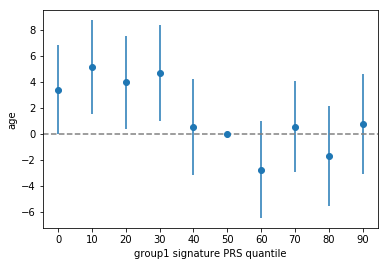

In [176]:
plt.errorbar(x=tcga_group1_beta["quant"].tolist(),y=tcga_group1_beta["odds"].tolist(),yerr=tcga_group1_beta["se"].tolist(),fmt="o")
plt.xlabel("group1 signature PRS quantile")
plt.ylabel("age")
plt.axhline(0,linestyle="--",color="gray")

In [177]:
tcga_prostate_prs=make_ukbb_prs("../data/genotypes/all.time.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:G:C_C', '6:29910358:G:C_C', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 9 genotypes


In [178]:
# tcga_rna=pd.read_csv("../data/plink-associations/phenotypes/pancanatlas/pheno_all_zcancer",delim_whitespace=True)
# tcga_rna=tcga_rna.replace(-9,np.nan)
# tcga_group1_prs=pd.merge(tcga_group1_prs,tcga_rna,on="IID",how="left")
cov=pd.read_csv("../data/plink-associations/cov/immune.filt.cov",delim_whitespace=True)
tcga_prostate_prs=pd.merge(tcga_prostate_prs,cov,on="IID",how="left")
sex=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",delim_whitespace=True,header=None)
sex[4]=sex[4].map({2:1,1:0})
mp_sex=dict(zip(sex[0],sex[4]))
tcga_prostate_prs["sex"]=tcga_prostate_prs["IID"].map(mp_sex)
tcga_prostate_prs["age"]=tcga_prostate_prs["age"].replace(-9,np.nan)

In [179]:
prad=pd.read_csv("/cellar/users/mpagadal/data/tcga/phenotypes/cancer-ids/PRAD",header=None,delimiter="\t")
prad=prad[0].tolist()

In [180]:
quant=[]
odds=[]
se=[]

for i in range(10):
    quant.append(str(10*i))
    
    #make groupings for linear regression
    tcga_prostate_prs=tcga_prostate_prs[tcga_prostate_prs["IID"].isin(prad)]
    cases=tcga_prostate_prs[(tcga_prostate_prs["PRS"]>tcga_prostate_prs["PRS"].quantile(.1*i))&(tcga_prostate_prs["PRS"]<tcga_prostate_prs["PRS"].quantile(.1*(i+1)))]["IID"].tolist()
    controls=tcga_prostate_prs[(tcga_prostate_prs["PRS"]>tcga_prostate_prs["PRS"].quantile(.5))&(tcga_prostate_prs["PRS"]<tcga_prostate_prs["PRS"].quantile(.6))]["IID"].tolist()
    
    df_filt=tcga_prostate_prs[tcga_prostate_prs["IID"].isin(cases+controls)]
    df_filt["group"]=np.where(df_filt["IID"].isin(cases),1,0)
    
    df_filt=df_filt[~df_filt["age"].isnull()]

    if i != 5:
        model=sm.OLS(df_filt["age"],df_filt[["group","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","sex"]]).fit()
        odds.append(model.params.tolist()[0])
        se.append(model.bse.tolist()[0])
        
    else:
        odds.append(0)
        se.append(0)


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [181]:
tcga_prostate_beta=pd.DataFrame({"quant":quant,"odds":odds,"se":se})

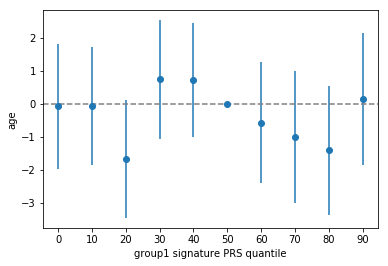

In [182]:
plt.errorbar(x=tcga_prostate_beta["quant"].tolist(),y=tcga_prostate_beta["odds"].tolist(),yerr=tcga_prostate_beta["se"].tolist(),fmt="o")
plt.xlabel("group1 signature PRS quantile")
plt.ylabel("age")
plt.axhline(0,linestyle="--",color="gray")

### DICE

In [71]:
def dice_prs(raw,sumstats,genes):
    
    '''
    raw: raw files with genotypes
    sumstats: summary stats for PRS construction
    genes: genes to assess in DICE RNA
    '''
    
    cell_lst=[]
    gene_lst=[]
    pear_lst=[]
    
    #construct PRS
    dice_sum_prs=make_ukbb_prs(raw,sumstats,sumstats["ID"].tolist())
    
    #get immune cell expression
    dice_rna="/cellar/controlled/dbGaP/phs001703_DICE/PhenoGenotypeFiles/RootStudyConsentSet_phs001703.IC_GeneExpression.v2.p1.c1.GRU/ExpressionFiles/RNA/"
    files=[ x for x in os.listdir(dice_rna) if ".csv" in x]
    print("{} cell types with RNA".format(len(files)))
    
    for x in files:
        print(x)
        rna=pd.read_csv(dice_rna+x)
        rna["Feature_name"]=rna["Feature_name"].str.split(".").str[0]
        rna["gene_name"]=rna["Feature_name"].map(ensembl)
        rna=rna[~rna["gene_name"].isnull()]
        rna_genes=rna[rna["gene_name"].isin(genes)]
        del rna_genes["Feature_name"]
        rna_genes=rna_genes.groupby("gene_name").mean().T
        
        rna_genes["IID"]=rna_genes.index.str.split("_").str[0]+"_"+rna_genes.index.str.split("_").str[0]+"_DNA"
        df_rna_pear=pd.merge(dice_sum_prs,rna_genes,on="IID",how="left")
        df_rna_pear=df_rna_pear.groupby("IID").mean().reset_index()
        for gene in [x for x in df_rna_pear.columns if x not in ["IID","PRS"]]:
            cell_lst.append(x.split(".csv")[0])
            gene_lst.append(gene)
            pear_lst.append(df_rna_pear["PRS"].corr(df_rna_pear[gene],method="pearson"))
        
    return(pd.DataFrame({"dice cell":cell_lst,"genes":gene_lst,"pearson":pear_lst}))
                

52 PRS snps
loading 52 snps
['5:96374150:G:A_G', '5:96374150:G:A_G', '1:151119769:T:A_A', '5:96200770:A:T_A', '1:150597890:G:A_A', '6:32438298:A:G_G', '6:32606941:T:C_T', '6:32605295:C:T_T', '5:96230122:G:T_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:C:T_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:T:C_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:G:A_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:C:T_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:C:T_C', '6:32660784:C:G_C', '11:65394322:A:G_A', '6:32796793:G:A_A', '6:32636866:A:T_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:G:A_A', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:T:G_T', '11:65580638:T:G_G', '1:150618632:A:C_C', '6:32586908:G:A_G', '6:32634405:C:T_C', '6:32692735:A:T_A', '6:32575658:G:C_C', '6:32683121:G:A_

<Figure size 144x360 with 0 Axes>

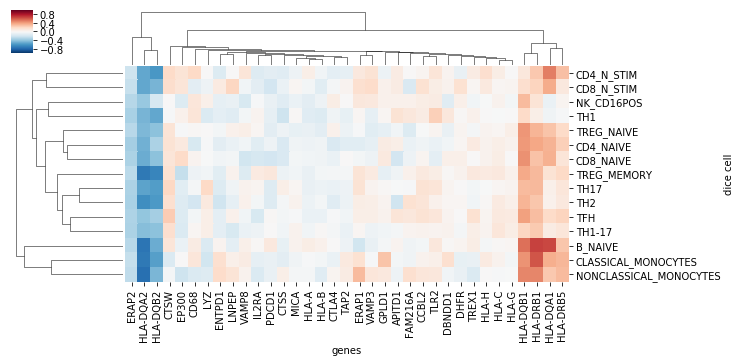

In [79]:
f=plt.figure(figsize=(2,5))
dice_pear=dice_prs("../data/genotypes/dice/dice.time.raw",group1_mhcII_sumstats,snps["file"].unique().tolist())
dice_pear=dice_pear[dice_pear["genes"].isin(ukbb_annot["file"].unique().tolist())]
ax=sns.clustermap(dice_pear.pivot(index="dice cell",columns="genes",values="pearson"),vmin=-1,vmax=1,cmap="RdBu_r",figsize=(10,5))
plt.savefig("../plots/fig5/dice.mhcII.prs.pdf")

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:T:C_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:A:G_A', '1:150658287:A:G_G', '6:29909372:C:G_G', '6:29910358:C:G_G', '6:32659609:T:C_C', '6:31783507:G:C_G']
0 snps missing weight
switching 10 genotypes
15 cell types with RNA
TH1-17.csv
TH17.csv
CD4_N_STIM.csv
TREG_NAIVE.csv
CLASSICAL_MONOCYTES.csv
TFH.csv
NK_CD16POS.csv
TH1.csv
TREG_MEMORY.csv
TH2.csv
NONCLASSICAL_MONOCYTES.csv
CD4_NAIVE.csv
B_NAIVE.csv
CD8_NAIVE.csv
CD8_N_STIM.csv


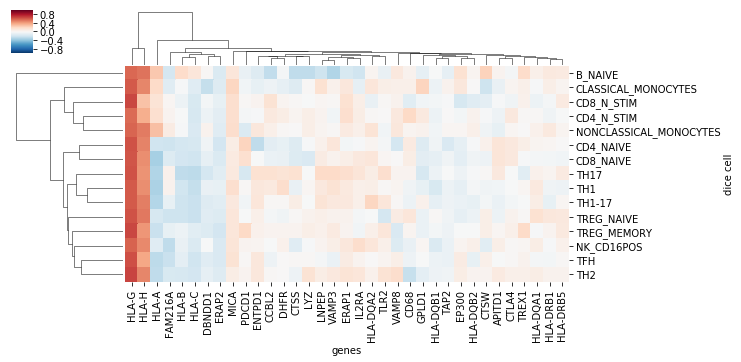

In [80]:
dice_pear=dice_prs("../data/genotypes/dice/dice.time.raw",prostate_sumstats,snps["file"].unique().tolist())
dice_pear=dice_pear[dice_pear["genes"].isin(ukbb_annot["file"].unique().tolist())]
sns.clustermap(dice_pear.pivot(index="dice cell",columns="genes",values="pearson"),vmin=-1,vmax=1,cmap="RdBu_r",figsize=(10,5))
plt.savefig("../plots/fig5/dice.prostate.prs.pdf")

### Make RNA plink files

In [104]:
dice_dir="/cellar/controlled/dbGaP/phs001703_DICE/PhenoGenotypeFiles/RootStudyConsentSet_phs001703.IC_GeneExpression.v2.p1.c1.GRU/ExpressionFiles/RNA/"
files=[x for x in os.listdir(dice_dir) if "csv" in x]

In [105]:
for x in files:
    rna=pd.read_csv(dice_dir+files[0])
    rna["Feature_name"]=rna["Feature_name"].str.split(".").str[0]
    rna["gene_name"]=rna["Feature_name"].map(ensembl)
    rna_genes=rna[~rna["gene_name"].isnull()]
    del rna_genes["Feature_name"]
    rna_genes=rna_genes.groupby("gene_name").mean().T
    rna_genes["IID"]=rna_genes.index.str.split("_").str[0]+"_"+rna_genes.index.str.split("_").str[0]+"_DNA"
    rna_genes["FID"]=0
    rna_genes.columns=[x.replace("_",".") for x in rna_genes.columns]
    rna_genes=rna_genes.groupby("IID").mean()
    rna_genes=rna_genes.reset_index()
    rna_genes[["FID","IID"]+rna_genes.columns.tolist()[:-2]].to_csv("/cellar/controlled/dbgap-genetic/phs001703_dice/plink-rna/"+x.split(".csv")[0]+".pheno",index=None,sep="\t")

In [81]:
" ".join([x.split(".pheno")[0] for x in os.listdir("/cellar/controlled/dbgap-genetic/phs001703_dice/plink-rna")])

'TREG_NAIVE TH1 CLASSICAL_MONOCYTES CD4_NAIVE CD8_N_STIM TH2 CD4_N_STIM CD8_NAIVE TFH NONCLASSICAL_MONOCYTES TREG_MEMORY TH17 NK_CD16POS TH1_17 B_NAIVE'

In [100]:
rna_genes=rna_genes.groupby("IID").mean()

In [102]:
rna_genes=rna_genes.reset_index()

In [103]:
rna_genes

,IID,5S.rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU13,snoU2-30,snoU2.19,snoU83B,snoZ278,snoZ40,snoZ6,snosnR66,yR211F11.2,FID
0,10_10_DNA,0.608457,0.076678,0.170726,0.552091,0.130229,8.354468,7.542820,0.026414,0.000000,...,1.154728,7.342810,2.141653,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
1,11_11_DNA,0.000000,0.319654,0.000000,0.417978,0.366765,10.955452,7.117287,0.000000,0.000000,...,1.210553,13.897773,1.621407,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
2,12_12_DNA,0.139808,0.267343,0.049097,0.421675,0.185005,5.163029,4.891539,0.018762,0.000000,...,0.694437,4.206211,1.635749,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
3,13_13_DNA,0.832748,0.603687,0.146837,0.262735,0.207489,7.933190,7.784465,0.028057,0.000000,...,0.830113,0.000000,1.223033,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
4,14_14_DNA,0.724670,0.312236,0.169658,1.639265,0.399559,8.102178,8.916725,0.032417,0.000000,...,0.479561,2.422469,0.706554,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
5,15_15_DNA,0.307732,0.471905,0.216136,1.430904,0.203608,7.871670,6.914470,0.000000,0.000000,...,0.549845,0.000000,3.600463,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
6,16_16_DNA,0.117431,0.159298,0.124049,0.414802,0.311206,6.315494,5.288904,0.015759,0.000000,...,1.097059,8.256330,0.686973,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
7,17_17_DNA,0.269069,0.031125,0.172829,0.742179,0.325622,4.001750,4.028282,0.033023,0.000000,...,0.537377,0.000000,0.719759,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
8,18_18_DNA,0.227468,0.014386,0.079881,1.543655,0.075251,4.444188,6.498282,0.000000,0.000000,...,0.541909,2.281179,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0
9,19_19_DNA,0.000000,0.045147,0.083565,1.495217,0.000000,3.627922,3.208009,0.000000,0.000000,...,0.519206,14.318197,2.088070,0.00000,0.0,0.0,0.000000,0.0,0.000000,0


In [74]:
rna_genes[["FID","IID"]+rna_genes.columns.tolist()[:-2]]

gene_name,FID,IID,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,snoU109,snoU13,snoU2-30,snoU2_19,snoU83B,snoZ278,snoZ40,snoZ6,snosnR66,yR211F11.2
1_1_RNA_TH1-17,0,1_1_DNA,0.000000,0.046130,0.128076,0.366666,0.000000,4.860178,6.165498,0.032629,...,0.000000,0.530511,2.438326,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
13_1_RNA_TH1-17,0,13_13_DNA,0.832748,0.603687,0.146837,0.262735,0.207489,7.933190,7.784465,0.028057,...,0.155306,0.830113,0.000000,1.223033,0.0,0.0,0.0,0.0,0.0,0.000000
25_1_RNA_TH1-17,0,25_25_DNA,0.000000,0.030381,0.168701,0.543342,0.238384,3.390788,4.009186,0.032234,...,0.178431,0.333801,4.817632,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
37_1_RNA_TH1-17,0,37_37_DNA,0.000000,0.168603,0.176345,0.504853,0.249185,6.436665,7.898113,0.033695,...,0.000000,0.299078,7.553865,2.203211,0.0,0.0,0.0,0.0,0.0,0.000000
49_1_RNA_TH1-17,0,49_49_DNA,0.000000,0.044000,0.040721,0.932628,0.153442,3.483372,4.540882,0.000000,...,0.000000,0.322289,2.325740,0.678341,0.0,0.0,0.0,0.0,0.0,0.000000
61_1_RNA_TH1-17,0,61_61_DNA,0.000000,0.163278,0.044360,0.380989,0.167154,5.192687,4.541204,0.000000,...,0.174729,0.501556,12.667874,3.694796,0.0,0.0,0.0,0.0,0.0,0.000000
73_1_RNA_TH1-17,0,73_73_DNA,0.000000,0.075418,0.000000,1.079018,0.078901,3.663153,4.516795,0.000000,...,0.329907,0.426145,7.175470,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
85_1_RNA_TH1-17,0,85_85_DNA,0.509738,0.016119,0.089504,0.384357,0.084316,7.023170,7.035647,0.000000,...,0.176274,0.657787,2.555973,1.490985,0.0,0.0,0.0,0.0,0.0,0.000000
2_1_RNA_TH1-17,0,2_2_DNA,0.000000,0.079906,0.369751,0.635130,0.000000,3.258082,5.475057,0.000000,...,0.000000,0.793521,4.223616,0.615944,0.0,0.0,0.0,0.0,0.0,0.000000
14_1_RNA_TH1-17,0,14_14_DNA,0.724670,0.312236,0.169658,1.639265,0.399559,8.102178,8.916725,0.032417,...,0.000000,0.479561,2.422469,0.706554,0.0,0.0,0.0,0.0,0.0,0.000000
